Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from glob import glob
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
# print the image count in train and test set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
# initializing batch and image size
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', batch_size=batch_size, 
    image_size=(img_height, img_width), seed=123, validation_split=0.2,
    subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train, labels='inferred', batch_size=batch_size, 
    image_size=(img_height, img_width), seed=123, validation_split=0.2,
    subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_of_classes = len(class_names)
print(class_names, num_of_classes)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

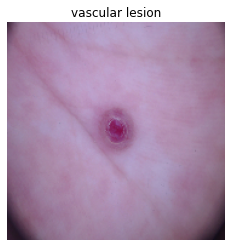

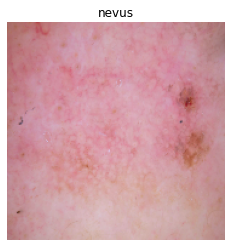

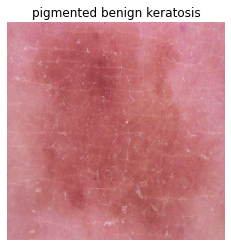

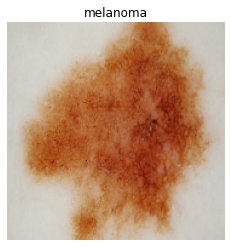

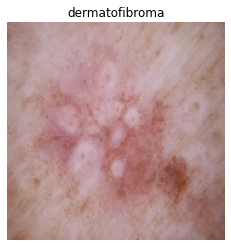

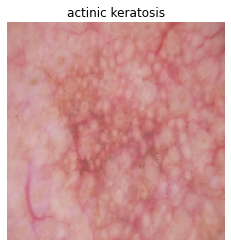

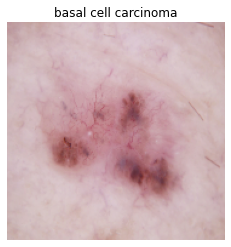

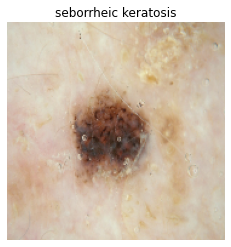

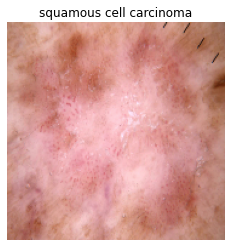

In [10]:
### your code goes here, you can use training or validation data to visualize
cls_list = []
for images, labels in train_ds.take(10):
    for i in range(num_of_classes):
        if class_names[labels[i]] not in cls_list:
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            plt.show()
            cls_list.append(class_names[labels[i]])

In [11]:
# checking the batch size
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
## configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# setting seed for model accuracy regeneration
np.random.seed(42)
tf.random.set_seed(42)

In [14]:
# creating the baseline model
model = Sequential([
    layers.experimental.preprocessing.Rescaling(
        1./255, input_shape=(img_height, img_width, 3)
    ),
    
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_of_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [17]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 26s 130ms/step - loss: 2.0983 - accuracy: 0.2051 - val_loss: 1.7500 - val_accuracy: 0.3826
Epoch 2/20
56/56 [==============================] - 2s 41ms/step - loss: 1.7025 - accuracy: 0.3825 - val_loss: 1.5186 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4904 - accuracy: 0.4807 - val_loss: 1.4355 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3688 - accuracy: 0.5274 - val_loss: 1.3837 - val_accuracy: 0.5168
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2560 - accuracy: 0.5484 - val_loss: 1.3964 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1622 - accuracy: 0.5793 - val_loss: 1.3545 - val_accuracy: 0.5526
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.0252 - accuracy: 0.6309 - val_loss: 1.4051 - val_accuracy: 0.5347
Epoch 8/20


### Visualizing training results

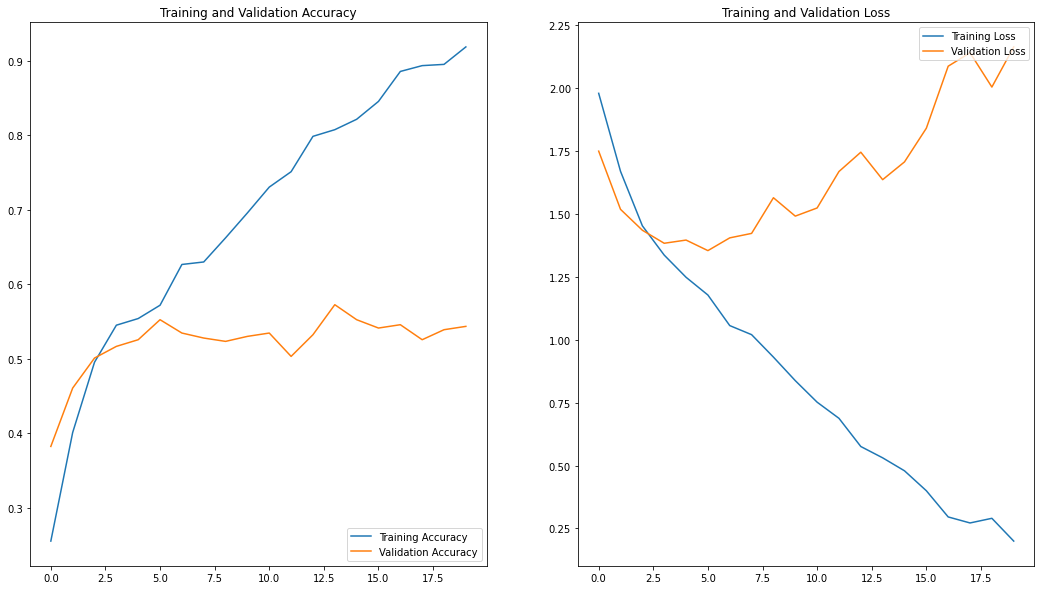

In [18]:
# Visualizing the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
As we can notice from the plots, the training accuracy and validation accuracy are off by large margins and the model has achieved only around __55%__ accuracy on the validation set while on the training set over __90%__ was achieved.<br>
<br>
This indicates that the model ___`overfitted`___.

### Write your findings here
In the above plots, the training accuracy is __increasing linearly__ over time, whereas validation accuracy _stagnates around 55%_ in the training process. Also, the difference in accuracy between training and validation accuracy is a  noticeable sign of ___overfitting___.

#### Data Augmentation

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(
        'horizontal_and_vertical', input_shape=(img_height, img_width, 3),
        seed=123
    ),
    layers.experimental.preprocessing.RandomRotation(0.1, seed=123),
    layers.experimental.preprocessing.RandomZoom(0.1, seed=123),
])

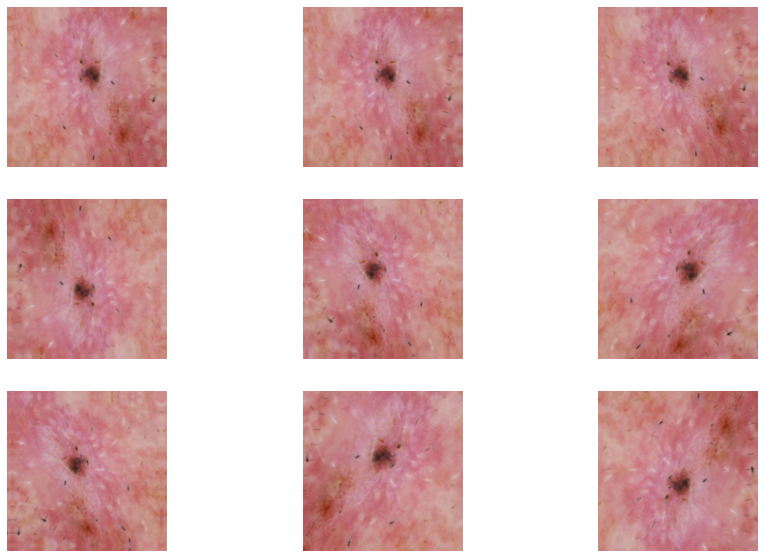

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(15, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

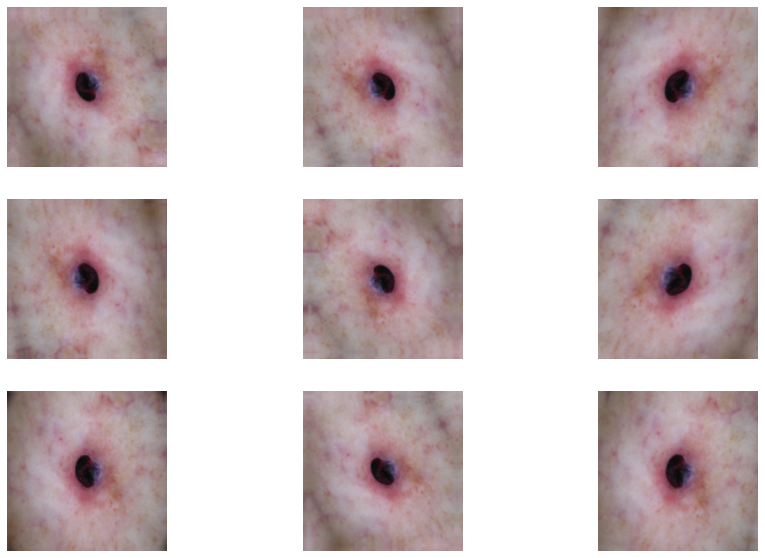

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of validation image.
plt.figure(figsize=(15, 10))
for images, _ in val_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model
Using `Dropouts` as a regularization parameter to control overfitting.

In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
aug_model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_of_classes)
])

### Compiling the model

In [23]:
## Compile the aug_model
aug_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
## Checking aug_model summary
aug_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 61ms/step - loss: 2.0602 - accuracy: 0.2255 - val_loss: 1.8574 - val_accuracy: 0.2796
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.8027 - accuracy: 0.3258 - val_loss: 1.6397 - val_accuracy: 0.4183
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.6408 - accuracy: 0.3880 - val_loss: 1.5396 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4806 - accuracy: 0.4738 - val_loss: 1.5573 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4567 - accuracy: 0.4763 - val_loss: 1.4392 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3752 - accuracy: 0.5254 - val_loss: 1.4221 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.3775 - accuracy: 0.5092 - val_loss: 1.6614 - val_accuracy: 0.4564
Epoch 8/20
56

### Visualizing the results

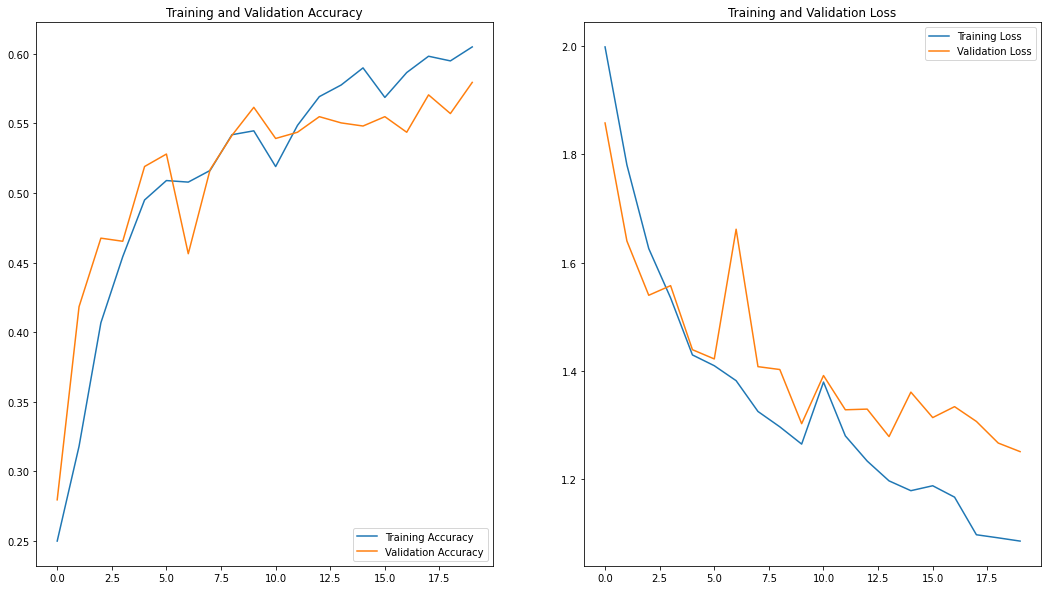

In [26]:
## visualizing traning results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

We can observe from the plots that the model is performing well on augmented data as there is __NO overfitting or underfitting__.<br>
However there can be improvements made to model to increase the accuracy.

### Handling class imbalances
#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
# getting paths of all classes of training data before augmentation
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026729.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027562.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0028393.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026765.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029915.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0027884.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0029827.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging C

In [28]:
# getting directory names for all classes of training data before augmentation
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [29]:
# creating a dictionary with path and lesion lists
dataframe_dict = dict(zip(path_list, lesion_list))

In [30]:
# creating a dataframe from dataframe_dict
original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path','Label'])

In [31]:
# get value count of classes before augmentation 
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
__`seborrheic keratosis`__ has 77 samples which is the least in the distribution.
#### - Which classes dominate the data in terms proportionate number of samples?
__`pigmented benign keratosis`__ and __`melanoma`__ are the dominant classes with _462_ and _438_ samples respectively in the training dataset.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [33]:
# creating new augmented images in the output folder
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1D52B8F150>: 100%|██████████| 500/500 [00:22<00:00, 22.38 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1D4F11F110>: 100%|██████████| 500/500 [00:21<00:00, 22.83 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F1D4F0820D0>:   0%|          | 1/500 [00:00<01:06,  7.50 Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1D5338E2D0>: 100%|██████████| 500/500 [00:22<00:00, 22.12 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F1D4F091C90>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F1D5338E490>: 100%|██████████| 500/500 [01:43<00:00,  4.82 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1D4F0B1E50>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F1D4F114F50>: 100%|██████████| 500/500 [00:49<00:00, 10.11 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1D4F140E10>: 100%|██████████| 500/500 [00:22<00:00, 21.91 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1D4F0A6510>: 100%|██████████| 500/500 [00:21<00:00, 23.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
# get the total number of new images added
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
# getting paths of all classes of training data AFTER augmentation
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]
path_list_new

['/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031292.jpg_0004cc35-aaeb-4558-a16e-625ac1e0fdc6.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_521ff017-ed83-40a4-b3f1-292c446bbc8b.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032854.jpg_575c5802-84d1-4d22-b6a6-bc09640a5e62.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_415f92d2-af36-45e8-91d1-dc99abd6baa9.jpg',
 '/content/gdrive/My Drive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029500.jpg_b0f058c8

In [36]:
# getting directory names for all classes of training data AFTER augmentation
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [37]:
# creating a dictionary with newly obtained path and lesion lists
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [38]:
# creating a dataframe from dataframe_dict_new
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path','Label'])
new_df = original_df.append(df2)

In [39]:
# getting the value counts of classes AFTER augmentation
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [40]:
# initializing batch and image size for augmented images
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [41]:
# creating training dataset AFTER augmentation
data_dir_train = data_dir_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [42]:
# creating validation dataset AFTER augmentation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [43]:
## creating the final model
final_model = Sequential([
    layers.experimental.preprocessing.Rescaling(
        1./255, input_shape=(img_height, img_width, 3)
    ),
    
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_of_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [44]:
## Compile the final model
final_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [45]:
## final model summary
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 22, 22, 64)       

#### **Todo:**  Train your model

In [46]:
## Training the final model
epochs = 10
for _ in range(2):
    print(f'Traning for {epochs} epochs')
    history = final_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs
    )

Traning for 10 epochs
Epoch 1/10
169/169 [==============================] - 56s 317ms/step - loss: 2.0404 - accuracy: 0.2131 - val_loss: 1.5398 - val_accuracy: 0.3979
Epoch 2/10
169/169 [==============================] - 53s 304ms/step - loss: 1.5692 - accuracy: 0.3959 - val_loss: 1.3954 - val_accuracy: 0.4484
Epoch 3/10
169/169 [==============================] - 53s 305ms/step - loss: 1.4270 - accuracy: 0.4340 - val_loss: 1.4850 - val_accuracy: 0.4751
Epoch 4/10
169/169 [==============================] - 52s 301ms/step - loss: 1.3185 - accuracy: 0.4954 - val_loss: 1.1767 - val_accuracy: 0.5538
Epoch 5/10
169/169 [==============================] - 53s 304ms/step - loss: 1.1961 - accuracy: 0.5289 - val_loss: 1.1465 - val_accuracy: 0.5679
Epoch 6/10
169/169 [==============================] - 53s 304ms/step - loss: 1.0218 - accuracy: 0.6129 - val_loss: 1.1319 - val_accuracy: 0.5664
Epoch 7/10
169/169 [==============================] - 54s 309ms/step - loss: 0.8908 - accuracy: 0.6552 - val

In [47]:
## Training the final model with 30 epochs
epochs = 30
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 51s 296ms/step - loss: 0.1919 - accuracy: 0.9279 - val_loss: 0.4559 - val_accuracy: 0.8641
Epoch 2/30
169/169 [==============================] - 52s 297ms/step - loss: 0.1672 - accuracy: 0.9351 - val_loss: 0.4912 - val_accuracy: 0.8701
Epoch 3/30
169/169 [==============================] - 51s 293ms/step - loss: 0.1443 - accuracy: 0.9414 - val_loss: 0.5965 - val_accuracy: 0.8307
Epoch 4/30
169/169 [==============================] - 53s 305ms/step - loss: 0.2253 - accuracy: 0.9162 - val_loss: 0.5144 - val_accuracy: 0.8448
Epoch 5/30
169/169 [==============================] - 52s 301ms/step - loss: 0.1783 - accuracy: 0.9238 - val_loss: 0.4722 - val_accuracy: 0.8716
Epoch 6/30
169/169 [==============================] - 51s 295ms/step - loss: 0.1396 - accuracy: 0.9440 - val_loss: 0.5889 - val_accuracy: 0.8523
Epoch 7/30
169/169 [==============================] - 52s 299ms/step - loss: 0.1617 - accuracy: 0.9394 - val_loss: 0.5162 - val_ac

#### **Todo:**  Visualize the model results

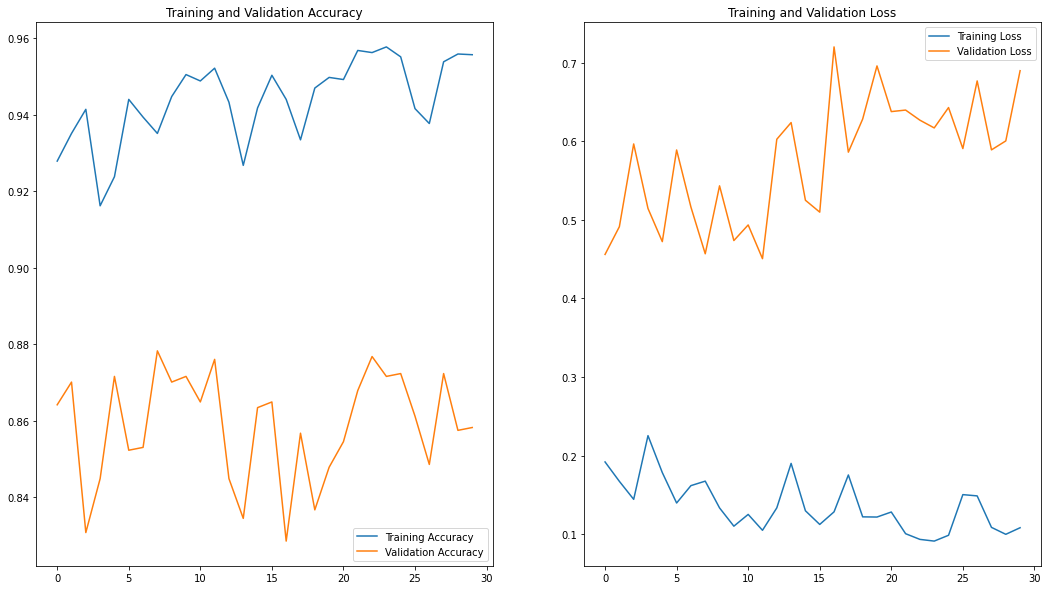

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Class rebalancing significantly __increased__ the accuracy of our model. Also there is no more overfitting or underfitting issue.<br>
The final model achieved a __training accuracy of 95%__ and __validation accuracy of 86%__.
<br>
The loss was hovering around __0.09 for training__ and it was around __0.68 for validation__.
